# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm

from random import sample
from torch.utils.data import Dataset
import cv2

from time import time
from torchvision import transforms

In [ ]:
cuda = torch.device('cuda')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [ ]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

norm_rgb = Normalize(mean=(0.48, 0.48, 0.48), std=(0.2, 0.2, 0.2))
norm_black_white = Normalize(mean=(0.48, 0.48), std=(0.2, 0.2))

un_norm_rgb = UnNormalize(mean=(0.48, 0.48, 0.48), std=(0.2, 0.2, 0.2))
un_norm_black_white = UnNormalize(mean=(0.48, 0.48), std=(0.2, 0.2))

In [ ]:
class BlackWhiteDataset(torch.utils.data.Dataset):
  def __init__(self, train, root='./data', download = True , transform = None):
    self.is_train = train
    self.transform = transform
    self.pure_trainset = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)


  def __getitem__(self, idx):
    image, label = self.pure_trainset[idx]
    black_white_image = cv2.cvtColor(image.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2GRAY)
    black_white_image = black_white_image.reshape(1 ,32 ,32)
    black_white_image = torch.tensor(black_white_image)
    # return norm_black_white(black_white_image), norm_rgb(image)
    return black_white_image, image

  def __len__(self):
    return len(self.pure_trainset)

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [ ]:
def load_balck_white_trainset():
  transform_train = transforms.Compose([
    transforms.ToTensor(),
  ])
  trainset = BlackWhiteDataset(
      root='./data', 
      train=True, 
      download=True, 
      transform=transform_train
      )
  return trainset


def split_val_data_balck_white(trainset, train_ratio=0.9):
  train_size = int(train_ratio * len(trainset))
  val_size = len(trainset) - train_size

  train_set, val_set = torch.utils.data.random_split(trainset, (train_size, val_size))
  return train_set, val_set

def get_train_val_balck_white_loader(train_set, val_set):
  trainloader = torch.utils.data.DataLoader(
      train_set, batch_size=256, shuffle=True, num_workers=2
      )
  valloader = torch.utils.data.DataLoader(
      val_set, batch_size=512, shuffle=False, num_workers=2
      )
  return trainloader, valloader


def laod_balck_white_testset():
  transform_test = transforms.Compose([
    transforms.ToTensor(),
  ])
  testset = BlackWhiteDataset(
      root='./data', 
      train=False, 
      download=True, 
      transform=transform_test
      )
  return testset

def get_balck_white_test_loader(testset):
  testloader = torch.utils.data.DataLoader(
      testset, batch_size=512, shuffle=False, num_workers=2
      )
  return testloader
    

black_white_trainset = load_balck_white_trainset()
black_white_train_set, black_white_val_set = split_val_data_balck_white(black_white_trainset)
black_white_trainloader, black_white_valloader = get_train_val_balck_white_loader(black_white_train_set, black_white_val_set)


black_white_testset = laod_balck_white_testset()
black_white_testloader = get_balck_white_test_loader(black_white_testset)

Files already downloaded and verified
Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

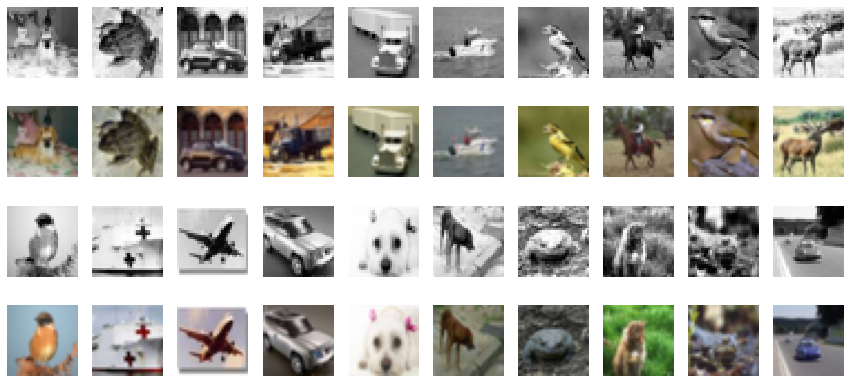

In [ ]:
fig = plt.figure(figsize=(15, 7))

balck_white_sample = sample([(black_white, rgb) for black_white, rgb in black_white_trainset], 20)

for both_sample in range(2):
  for i in range(10):
    black_withe_iamge , rgb = balck_white_sample[both_sample * 10 + i]
    fig.add_subplot(4, 10, both_sample * 20 + i + 1)
    # plt.imshow(un_norm_black_white(black_withe_iamge.clone().detach()).permute(1, 2, 0).numpy().reshape(32, 32), cmap='Greys_r', interpolation='nearest')
    plt.imshow(black_withe_iamge.permute(1, 2, 0).numpy().reshape(32, 32), cmap='Greys_r', interpolation='nearest')
    plt.axis("off")
    fig.add_subplot(4, 10, both_sample * 20 + i + 10 + 1)
    # plt.imshow(un_norm_rgb(rgb.clone().detach()).permute(1, 2, 0).numpy())
    plt.imshow(rgb.permute(1, 2, 0).numpy())
    plt.axis("off")


plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [ ]:
class ColNN(nn.Module):
    def __init__(self):
        super(ColNN, self).__init__()

        self.down1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
        )
        
        self.fc1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
        )
        self.fc2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
        )
        self.fc3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
        )

        
    def forward(self, x):
        d1 = self.down1(x)
        d1_relu = F.relu(d1)
        d2 = self.down2(d1_relu)
        d2_relu = F.relu(d2)
        d3 = self.down3(d2_relu)
        d3_relu = F.relu(d3)

        f1 = self.fc1(d3_relu)
        f1_relu = F.relu(f1)
        f2 = self.fc2(f1_relu)
        f2_relu = F.relu(f2)
        f3 = self.fc3(f2_relu)
        f3_relu = F.relu(f3)

        u1 = self.up1(f3_relu)
        u1_relu = F.relu(u1)
        u2 = self.up2(u1_relu)
        u2_relu = F.relu(u2)
        out = self.up3(u2_relu)
        
        return out

net = ColNN()
net = net.to('cuda')

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [ ]:
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-2)
criterion = nn.MSELoss()

def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader):
    count = 0
    average_loss = [0]
    i = 0

    net.train()
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (black_withe_iamge, rgb) in pbar:
          black_withe_iamge = black_withe_iamge.to(device)
          rgb = rgb.to(device)
          pred = net(black_withe_iamge)
          loss = criterion(pred, rgb)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          average_loss[-1] += loss.item()
          pbar.set_description(str(i))
          count += 1
    return average_loss[-1] / count

def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader):
    count = 0
    average_loss = [0]
    i = 0
    net.eval()
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (black_withe_iamge, rgb) in pbar:
          black_withe_iamge = black_withe_iamge.to(device)
          rgb = rgb.to(device)
          predict = net(black_withe_iamge)
          loss = criterion(predict, rgb)
          average_loss[-1] += loss.item()
          pbar.set_description(str(i))
          count += 1
    return average_loss[-1] / count

In [ ]:
epochs = 100
train_loss = []
val_loss = []

for e in range(epochs):

    start_time = time()

    train_res = train_epoch(net, criterion, optimizer, black_white_trainloader)
    train_loss.append(train_res)
    print('Train Loss:',train_res)
    val_res = eval_epoch(net, criterion, black_white_valloader)
    val_loss.append(val_res)
    print('Validation Loss:',val_res)

    end_time = time()

    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

175: 100%|██████████| 176/176 [00:12<00:00, 14.29it/s]

  Train Loss: 0.053535378919067705



9: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]

  Validation Loss: 0.024947321601212026
Epoch   1 finished in 14.12s



175: 100%|██████████| 176/176 [00:14<00:00, 12.14it/s]

  Train Loss: 0.022125369086014954



9: 100%|██████████| 10/10 [00:01<00:00,  9.28it/s]

  Validation Loss: 0.019313470274209977
Epoch   2 finished in 15.86s



175: 100%|██████████| 176/176 [00:10<00:00, 17.01it/s]

  Train Loss: 0.016887652206192302



9: 100%|██████████| 10/10 [00:01<00:00,  9.25it/s]

  Validation Loss: 0.015432551503181458
Epoch   3 finished in 11.67s



175: 100%|██████████| 176/176 [00:13<00:00, 12.98it/s]

  Train Loss: 0.014684514804023573



9: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]

  Validation Loss: 0.014172898046672345
Epoch   4 finished in 15.38s



175: 100%|██████████| 176/176 [00:12<00:00, 14.62it/s]


  Train Loss: 0.013676292183597318


9: 100%|██████████| 10/10 [00:01<00:00,  9.25it/s]

  Validation Loss: 0.014232831820845605
Epoch   5 finished in 13.40s



175: 100%|██████████| 176/176 [00:10<00:00, 17.19it/s]

  Train Loss: 0.013151595035610213



9: 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

  Validation Loss: 0.01364564374089241
Epoch   6 finished in 11.53s



175: 100%|██████████| 176/176 [00:10<00:00, 16.59it/s]


  Train Loss: 0.012555022798055275


9: 100%|██████████| 10/10 [00:01<00:00,  9.43it/s]

  Validation Loss: 0.012728412263095379
Epoch   7 finished in 11.92s



175: 100%|██████████| 176/176 [00:10<00:00, 16.68it/s]

  Train Loss: 0.01217404370915822



9: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s]

  Validation Loss: 0.01179666854441166
Epoch   8 finished in 11.85s



175: 100%|██████████| 176/176 [00:10<00:00, 16.63it/s]

  Train Loss: 0.01139531698374247



9: 100%|██████████| 10/10 [00:01<00:00,  9.46it/s]

  Validation Loss: 0.010932303871959448
Epoch   9 finished in 11.89s



175: 100%|██████████| 176/176 [00:10<00:00, 16.66it/s]

  Train Loss: 0.010765025614422153



9: 100%|██████████| 10/10 [00:01<00:00,  9.57it/s]

  Validation Loss: 0.01055787829682231
Epoch  10 finished in 11.83s



175: 100%|██████████| 176/176 [00:10<00:00, 17.19it/s]

  Train Loss: 0.01055998254080557



9: 100%|██████████| 10/10 [00:01<00:00,  9.73it/s]

  Validation Loss: 0.010975657869130373
Epoch  11 finished in 11.50s



175: 100%|██████████| 176/176 [00:10<00:00, 16.30it/s]

  Train Loss: 0.010424326221585612



9: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]

  Validation Loss: 0.010678805690258742
Epoch  12 finished in 12.13s



175: 100%|██████████| 176/176 [00:10<00:00, 16.39it/s]

  Train Loss: 0.009828546846454794



9: 100%|██████████| 10/10 [00:01<00:00,  9.12it/s]

  Validation Loss: 0.010404121782630681
Epoch  13 finished in 12.07s



175: 100%|██████████| 176/176 [00:10<00:00, 16.52it/s]

  Train Loss: 0.009552223851311614



9: 100%|██████████| 10/10 [00:01<00:00,  9.36it/s]

  Validation Loss: 0.009556775167584419
Epoch  14 finished in 11.95s



175: 100%|██████████| 176/176 [00:11<00:00, 15.87it/s]

  Train Loss: 0.009318225138651376



9: 100%|██████████| 10/10 [00:01<00:00,  9.59it/s]

  Validation Loss: 0.0094545166939497
Epoch  15 finished in 12.35s



175: 100%|██████████| 176/176 [00:10<00:00, 16.95it/s]

  Train Loss: 0.00892450320481492



9: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s]

  Validation Loss: 0.008819854445755481
Epoch  16 finished in 11.69s



175: 100%|██████████| 176/176 [00:10<00:00, 16.50it/s]

  Train Loss: 0.008608641153180295



9: 100%|██████████| 10/10 [00:01<00:00,  9.25it/s]

  Validation Loss: 0.008741117268800735
Epoch  17 finished in 11.98s



175: 100%|██████████| 176/176 [00:10<00:00, 16.80it/s]

  Train Loss: 0.008398775080091913



9: 100%|██████████| 10/10 [00:01<00:00,  9.58it/s]

  Validation Loss: 0.00884456057101488
Epoch  18 finished in 11.77s



175: 100%|██████████| 176/176 [00:10<00:00, 16.70it/s]


  Train Loss: 0.008365420603447339


9: 100%|██████████| 10/10 [00:01<00:00,  9.13it/s]

  Validation Loss: 0.008449561055749654
Epoch  19 finished in 11.87s



175: 100%|██████████| 176/176 [00:10<00:00, 16.06it/s]

  Train Loss: 0.008163572810272772



9: 100%|██████████| 10/10 [00:01<00:00,  9.11it/s]

  Validation Loss: 0.008275117073208094
Epoch  20 finished in 12.30s



175: 100%|██████████| 176/176 [00:10<00:00, 16.39it/s]

  Train Loss: 0.007990558965089307



9: 100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


  Validation Loss: 0.008561375364661217
Epoch  21 finished in 12.04s


175: 100%|██████████| 176/176 [00:10<00:00, 16.81it/s]

  Train Loss: 0.007878511175724932



9: 100%|██████████| 10/10 [00:01<00:00,  9.31it/s]

  Validation Loss: 0.008284362638369203
Epoch  22 finished in 11.77s



175: 100%|██████████| 176/176 [00:10<00:00, 16.91it/s]

  Train Loss: 0.007756189252673225



9: 100%|██████████| 10/10 [00:01<00:00,  9.58it/s]

  Validation Loss: 0.008259213902056218
Epoch  23 finished in 11.69s



175: 100%|██████████| 176/176 [00:10<00:00, 16.43it/s]

  Train Loss: 0.007574637700930576



9: 100%|██████████| 10/10 [00:01<00:00,  9.19it/s]

  Validation Loss: 0.007966539915651083
Epoch  24 finished in 12.04s



175: 100%|██████████| 176/176 [00:10<00:00, 16.19it/s]


  Train Loss: 0.007477015066383915


9: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

  Validation Loss: 0.008668825775384904
Epoch  25 finished in 12.17s



175: 100%|██████████| 176/176 [00:10<00:00, 16.16it/s]

  Train Loss: 0.00740101777641526



9: 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]

  Validation Loss: 0.0078007963486015795
Epoch  26 finished in 12.21s



175: 100%|██████████| 176/176 [00:10<00:00, 16.58it/s]

  Train Loss: 0.007293956475967372



9: 100%|██████████| 10/10 [00:01<00:00,  9.52it/s]

  Validation Loss: 0.008227601135149597
Epoch  27 finished in 11.91s



175: 100%|██████████| 176/176 [00:10<00:00, 16.69it/s]

  Train Loss: 0.007223424731901931



9: 100%|██████████| 10/10 [00:01<00:00,  9.48it/s]


  Validation Loss: 0.008309392770752311
Epoch  28 finished in 11.84s


175: 100%|██████████| 176/176 [00:10<00:00, 16.73it/s]

  Train Loss: 0.0070746124441608445



9: 100%|██████████| 10/10 [00:01<00:00,  9.10it/s]

  Validation Loss: 0.008046113653108478
Epoch  29 finished in 11.85s



175: 100%|██████████| 176/176 [00:10<00:00, 16.11it/s]


  Train Loss: 0.007087230007693341


9: 100%|██████████| 10/10 [00:01<00:00,  9.21it/s]

  Validation Loss: 0.008780715893954039
Epoch  30 finished in 12.25s



175: 100%|██████████| 176/176 [00:10<00:00, 16.41it/s]

  Train Loss: 0.007011015798938884



9: 100%|██████████| 10/10 [00:01<00:00,  9.57it/s]

  Validation Loss: 0.007804540731012821
Epoch  31 finished in 12.01s



175: 100%|██████████| 176/176 [00:10<00:00, 16.76it/s]

  Train Loss: 0.006900555880168791



9: 100%|██████████| 10/10 [00:01<00:00,  9.54it/s]

  Validation Loss: 0.007723333640024066
Epoch  32 finished in 11.78s



175: 100%|██████████| 176/176 [00:10<00:00, 16.63it/s]

  Train Loss: 0.006786268236200241



9: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s]

  Validation Loss: 0.00864996574819088
Epoch  33 finished in 11.85s



175: 100%|██████████| 176/176 [00:10<00:00, 16.80it/s]

  Train Loss: 0.00663265947051431



9: 100%|██████████| 10/10 [00:01<00:00,  9.65it/s]

  Validation Loss: 0.007557563995942473
Epoch  34 finished in 11.75s



175: 100%|██████████| 176/176 [00:10<00:00, 16.60it/s]

  Train Loss: 0.006537152438382195



9: 100%|██████████| 10/10 [00:01<00:00,  9.07it/s]

  Validation Loss: 0.00839590998366475
Epoch  35 finished in 11.95s



175: 100%|██████████| 176/176 [00:10<00:00, 16.05it/s]

  Train Loss: 0.006333246774209494



9: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

  Validation Loss: 0.008396419929340482
Epoch  36 finished in 12.32s



175: 100%|██████████| 176/176 [00:10<00:00, 16.40it/s]


  Train Loss: 0.006296513599491763


9: 100%|██████████| 10/10 [00:01<00:00,  9.26it/s]

  Validation Loss: 0.007698280457407236
Epoch  37 finished in 12.04s



175: 100%|██████████| 176/176 [00:10<00:00, 16.55it/s]

  Train Loss: 0.006192556344269013



9: 100%|██████████| 10/10 [00:01<00:00,  9.30it/s]


  Validation Loss: 0.008194594690576196
Epoch  38 finished in 11.94s


175: 100%|██████████| 176/176 [00:10<00:00, 16.48it/s]


  Train Loss: 0.006014522302641787


9: 100%|██████████| 10/10 [00:01<00:00,  9.34it/s]

  Validation Loss: 0.007767208339646459
Epoch  39 finished in 11.97s



175: 100%|██████████| 176/176 [00:10<00:00, 16.41it/s]

  Train Loss: 0.005923100466712971



9: 100%|██████████| 10/10 [00:01<00:00,  9.19it/s]

  Validation Loss: 0.0075750196352601055
Epoch  40 finished in 12.05s



175: 100%|██████████| 176/176 [00:10<00:00, 16.26it/s]

  Train Loss: 0.005751204904465174



9: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s]

  Validation Loss: 0.008275869721546768
Epoch  41 finished in 12.13s



175: 100%|██████████| 176/176 [00:10<00:00, 16.03it/s]

  Train Loss: 0.005669335149419071



9: 100%|██████████| 10/10 [00:01<00:00,  9.30it/s]

  Validation Loss: 0.00786881260573864
Epoch  42 finished in 12.29s



175: 100%|██████████| 176/176 [00:10<00:00, 16.66it/s]

  Train Loss: 0.005568361481313001



9: 100%|██████████| 10/10 [00:01<00:00,  9.52it/s]

  Validation Loss: 0.008489261660724879
Epoch  43 finished in 11.85s



175: 100%|██████████| 176/176 [00:10<00:00, 16.79it/s]

  Train Loss: 0.005436996553643522



9: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]

  Validation Loss: 0.00810406133532524
Epoch  44 finished in 11.81s



175: 100%|██████████| 176/176 [00:10<00:00, 16.48it/s]


  Train Loss: 0.00530273084719242


9: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]

  Validation Loss: 0.007901416951790452
Epoch  45 finished in 12.04s



175: 100%|██████████| 176/176 [00:11<00:00, 15.88it/s]

  Train Loss: 0.005213889327768067



9: 100%|██████████| 10/10 [00:01<00:00,  9.00it/s]

  Validation Loss: 0.009562401752918958
Epoch  46 finished in 12.43s



175: 100%|██████████| 176/176 [00:11<00:00, 15.85it/s]


  Train Loss: 0.005060485908126628


9: 100%|██████████| 10/10 [00:01<00:00,  9.03it/s]

  Validation Loss: 0.009402448125183583
Epoch  47 finished in 12.47s



175: 100%|██████████| 176/176 [00:10<00:00, 16.29it/s]

  Train Loss: 0.00508448528919623



9: 100%|██████████| 10/10 [00:01<00:00,  9.64it/s]


  Validation Loss: 0.007695460366085172
Epoch  48 finished in 12.07s


175: 100%|██████████| 176/176 [00:10<00:00, 16.37it/s]

  Train Loss: 0.00492513342495923



9: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]

  Validation Loss: 0.007571707572788
Epoch  49 finished in 12.07s



175: 100%|██████████| 176/176 [00:10<00:00, 16.39it/s]

  Train Loss: 0.00480511485577815



9: 100%|██████████| 10/10 [00:01<00:00,  9.31it/s]

  Validation Loss: 0.007628863630816341
Epoch  50 finished in 12.06s



175: 100%|██████████| 176/176 [00:10<00:00, 16.59it/s]

  Train Loss: 0.004678591183619574



9: 100%|██████████| 10/10 [00:01<00:00,  9.23it/s]

  Validation Loss: 0.0084594895131886
Epoch  51 finished in 11.92s



175: 100%|██████████| 176/176 [00:10<00:00, 16.42it/s]

  Train Loss: 0.004669859042306515



9: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

  Validation Loss: 0.008109938912093639
Epoch  52 finished in 12.09s



175: 100%|██████████| 176/176 [00:11<00:00, 15.87it/s]

  Train Loss: 0.004606557277094742



9: 100%|██████████| 10/10 [00:01<00:00,  9.08it/s]

  Validation Loss: 0.00788145437836647
Epoch  53 finished in 12.43s



175: 100%|██████████| 176/176 [00:10<00:00, 16.00it/s]

  Train Loss: 0.004609341865447773



9: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

  Validation Loss: 0.0077753834892064335
Epoch  54 finished in 12.35s



175: 100%|██████████| 176/176 [00:10<00:00, 16.08it/s]

  Train Loss: 0.004576840275231833



9: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

  Validation Loss: 0.008417313918471336
Epoch  55 finished in 12.24s



175: 100%|██████████| 176/176 [00:10<00:00, 16.38it/s]

  Train Loss: 0.00442736852644223



9: 100%|██████████| 10/10 [00:01<00:00,  9.12it/s]

  Validation Loss: 0.007765893265604973
Epoch  56 finished in 12.08s



175: 100%|██████████| 176/176 [00:11<00:00, 15.79it/s]

  Train Loss: 0.004434134155003862



9: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]

  Validation Loss: 0.00841801194474101
Epoch  57 finished in 12.49s



175: 100%|██████████| 176/176 [00:10<00:00, 16.02it/s]

  Train Loss: 0.004383175795241682



9: 100%|██████████| 10/10 [00:01<00:00,  9.45it/s]

  Validation Loss: 0.007938588690012693
Epoch  58 finished in 12.31s



175: 100%|██████████| 176/176 [00:10<00:00, 16.70it/s]

  Train Loss: 0.004259332722127015



9: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]

  Validation Loss: 0.007766751851886511
Epoch  59 finished in 11.90s



175: 100%|██████████| 176/176 [00:10<00:00, 16.28it/s]

  Train Loss: 0.004160907746567814



9: 100%|██████████| 10/10 [00:01<00:00,  9.32it/s]

  Validation Loss: 0.007593536237254739
Epoch  60 finished in 12.13s



175: 100%|██████████| 176/176 [00:10<00:00, 16.50it/s]

  Train Loss: 0.004228635986113328



9: 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

  Validation Loss: 0.007772425469011068
Epoch  61 finished in 11.97s



175: 100%|██████████| 176/176 [00:10<00:00, 16.55it/s]

  Train Loss: 0.004293735960593701



9: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

  Validation Loss: 0.00819903202354908
Epoch  62 finished in 11.93s



175: 100%|██████████| 176/176 [00:10<00:00, 16.17it/s]

  Train Loss: 0.004167345044234852



9: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]

  Validation Loss: 0.007846928434446454
Epoch  63 finished in 12.30s



175: 100%|██████████| 176/176 [00:11<00:00, 15.70it/s]

  Train Loss: 0.004012086322869767



9: 100%|██████████| 10/10 [00:01<00:00,  8.97it/s]

  Validation Loss: 0.007322528259828686
Epoch  64 finished in 12.57s



175: 100%|██████████| 176/176 [00:11<00:00, 15.79it/s]

  Train Loss: 0.004082782145071013



9: 100%|██████████| 10/10 [00:01<00:00,  8.92it/s]

  Validation Loss: 0.007625159015879035
Epoch  65 finished in 12.53s



175: 100%|██████████| 176/176 [00:10<00:00, 16.25it/s]

  Train Loss: 0.003941104687824422



9: 100%|██████████| 10/10 [00:01<00:00,  9.48it/s]

  Validation Loss: 0.007636115700006485
Epoch  66 finished in 12.13s



175: 100%|██████████| 176/176 [00:11<00:00, 15.92it/s]

  Train Loss: 0.003930631948275153



9: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]

  Validation Loss: 0.007497605634853244
Epoch  67 finished in 12.41s



175: 100%|██████████| 176/176 [00:11<00:00, 15.76it/s]

  Train Loss: 0.003854065614921803



9: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]

  Validation Loss: 0.007872892683371902
Epoch  68 finished in 12.57s



175: 100%|██████████| 176/176 [00:10<00:00, 16.01it/s]

  Train Loss: 0.0038795910487268966



9: 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

  Validation Loss: 0.0076110541820526125
Epoch  69 finished in 12.29s



175: 100%|██████████| 176/176 [00:10<00:00, 16.18it/s]

  Train Loss: 0.0038068939214678144



9: 100%|██████████| 10/10 [00:01<00:00,  9.51it/s]

  Validation Loss: 0.007423880137503147
Epoch  70 finished in 12.19s



175: 100%|██████████| 176/176 [00:10<00:00, 16.27it/s]


  Train Loss: 0.003756868184692311


9: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]

  Validation Loss: 0.007436213875189423
Epoch  71 finished in 12.14s



175: 100%|██████████| 176/176 [00:10<00:00, 16.28it/s]

  Train Loss: 0.003860287254528058



9: 100%|██████████| 10/10 [00:01<00:00,  9.37it/s]

  Validation Loss: 0.007301984960213304
Epoch  72 finished in 12.11s



175: 100%|██████████| 176/176 [00:10<00:00, 16.37it/s]

  Train Loss: 0.003713277402725494



9: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

  Validation Loss: 0.007328256359323859
Epoch  73 finished in 12.08s



175: 100%|██████████| 176/176 [00:10<00:00, 16.20it/s]

  Train Loss: 0.0037725280126323923



9: 100%|██████████| 10/10 [00:01<00:00,  8.89it/s]

  Validation Loss: 0.007555508706718683
Epoch  74 finished in 12.22s



175: 100%|██████████| 176/176 [00:11<00:00, 15.58it/s]

  Train Loss: 0.0036162593751214445



9: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]

  Validation Loss: 0.007407772820442915
Epoch  75 finished in 12.67s



175: 100%|██████████| 176/176 [00:11<00:00, 15.78it/s]

  Train Loss: 0.0036788790484107185



9: 100%|██████████| 10/10 [00:01<00:00,  9.48it/s]


  Validation Loss: 0.007487827772274613
Epoch  76 finished in 12.46s


175: 100%|██████████| 176/176 [00:10<00:00, 16.29it/s]

  Train Loss: 0.003632600751271556



9: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]

  Validation Loss: 0.007593920920044184
Epoch  77 finished in 12.18s



175: 100%|██████████| 176/176 [00:11<00:00, 15.60it/s]


  Train Loss: 0.003574659617945806


9: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

  Validation Loss: 0.007471915613859892
Epoch  78 finished in 12.64s



175: 100%|██████████| 176/176 [00:10<00:00, 16.18it/s]

  Train Loss: 0.0035614099073096772



9: 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

  Validation Loss: 0.007643595291301608
Epoch  79 finished in 12.18s



175: 100%|██████████| 176/176 [00:10<00:00, 16.51it/s]

  Train Loss: 0.0035799447730162433



9: 100%|██████████| 10/10 [00:01<00:00,  9.23it/s]

  Validation Loss: 0.0077086527366191145
Epoch  80 finished in 11.99s



175: 100%|██████████| 176/176 [00:10<00:00, 16.14it/s]


  Train Loss: 0.0034924489617961544


9: 100%|██████████| 10/10 [00:01<00:00,  9.17it/s]

  Validation Loss: 0.00765105988830328
Epoch  81 finished in 12.24s



175: 100%|██████████| 176/176 [00:10<00:00, 16.19it/s]

  Train Loss: 0.00353214369203091



9: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]

  Validation Loss: 0.007638331595808267
Epoch  82 finished in 12.17s



175: 100%|██████████| 176/176 [00:10<00:00, 16.17it/s]

  Train Loss: 0.003487818421986462



9: 100%|██████████| 10/10 [00:01<00:00,  9.20it/s]

  Validation Loss: 0.00844482984393835
Epoch  83 finished in 12.21s



175: 100%|██████████| 176/176 [00:10<00:00, 16.30it/s]

  Train Loss: 0.0034202557858820496



9: 100%|██████████| 10/10 [00:01<00:00,  9.38it/s]

  Validation Loss: 0.00724213202483952
Epoch  84 finished in 12.12s



175: 100%|██████████| 176/176 [00:11<00:00, 15.62it/s]

  Train Loss: 0.0034334168713857334



9: 100%|██████████| 10/10 [00:01<00:00,  8.96it/s]

  Validation Loss: 0.007643475569784642
Epoch  85 finished in 12.63s



175: 100%|██████████| 176/176 [00:11<00:00, 15.54it/s]


  Train Loss: 0.003437616195614365


9: 100%|██████████| 10/10 [00:01<00:00,  8.92it/s]

  Validation Loss: 0.007498117536306382
Epoch  86 finished in 12.70s



175: 100%|██████████| 176/176 [00:11<00:00, 15.70it/s]

  Train Loss: 0.0033607151272008196



9: 100%|██████████| 10/10 [00:01<00:00,  9.43it/s]

  Validation Loss: 0.007206492917612195
Epoch  87 finished in 12.53s



175: 100%|██████████| 176/176 [00:10<00:00, 16.45it/s]


  Train Loss: 0.0033466210033194247


9: 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]

  Validation Loss: 0.007418809831142426
Epoch  88 finished in 11.99s



175: 100%|██████████| 176/176 [00:11<00:00, 15.84it/s]

  Train Loss: 0.003425194371216507



9: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]

  Validation Loss: 0.007552163442596793
Epoch  89 finished in 12.46s



175: 100%|██████████| 176/176 [00:11<00:00, 15.83it/s]

  Train Loss: 0.003425165132450109



9: 100%|██████████| 10/10 [00:01<00:00,  9.18it/s]

  Validation Loss: 0.0079251604154706
Epoch  90 finished in 12.46s



175: 100%|██████████| 176/176 [00:10<00:00, 16.19it/s]

  Train Loss: 0.00341645983280614



9: 100%|██████████| 10/10 [00:01<00:00,  9.40it/s]

  Validation Loss: 0.007676397589966655
Epoch  91 finished in 12.19s



175: 100%|██████████| 176/176 [00:10<00:00, 16.36it/s]

  Train Loss: 0.0033667390909448095



9: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]

  Validation Loss: 0.007799186557531357
Epoch  92 finished in 12.13s



175: 100%|██████████| 176/176 [00:10<00:00, 16.27it/s]

  Train Loss: 0.0033750912791054525



9: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

  Validation Loss: 0.007294726790860295
Epoch  93 finished in 12.14s



175: 100%|██████████| 176/176 [00:10<00:00, 16.18it/s]

  Train Loss: 0.0032656279495726762



9: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s]

  Validation Loss: 0.007512621162459254
Epoch  94 finished in 12.20s



175: 100%|██████████| 176/176 [00:11<00:00, 15.64it/s]

  Train Loss: 0.003255571650118906



9: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

  Validation Loss: 0.007547010574489832
Epoch  95 finished in 12.62s



175: 100%|██████████| 176/176 [00:11<00:00, 15.71it/s]

  Train Loss: 0.0032743456315736034



9: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]

  Validation Loss: 0.007592784706503153
Epoch  96 finished in 12.58s



175: 100%|██████████| 176/176 [00:10<00:00, 16.05it/s]

  Train Loss: 0.0032836481008086016



9: 100%|██████████| 10/10 [00:01<00:00,  9.65it/s]

  Validation Loss: 0.007814596639946103
Epoch  97 finished in 12.24s



175: 100%|██████████| 176/176 [00:10<00:00, 16.35it/s]


  Train Loss: 0.0032429827948693524


9: 100%|██████████| 10/10 [00:01<00:00,  9.28it/s]

  Validation Loss: 0.007499971333891154
Epoch  98 finished in 12.09s



175: 100%|██████████| 176/176 [00:10<00:00, 16.22it/s]

  Train Loss: 0.003196230316957967



9: 100%|██████████| 10/10 [00:01<00:00,  9.47it/s]

  Validation Loss: 0.007535501103848219
Epoch  99 finished in 12.15s



175: 100%|██████████| 176/176 [00:10<00:00, 16.43it/s]


  Train Loss: 0.003243934873766689


9: 100%|██████████| 10/10 [00:01<00:00,  9.56it/s]

  Validation Loss: 0.0073431506752967834
Epoch 100 finished in 12.00s


### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

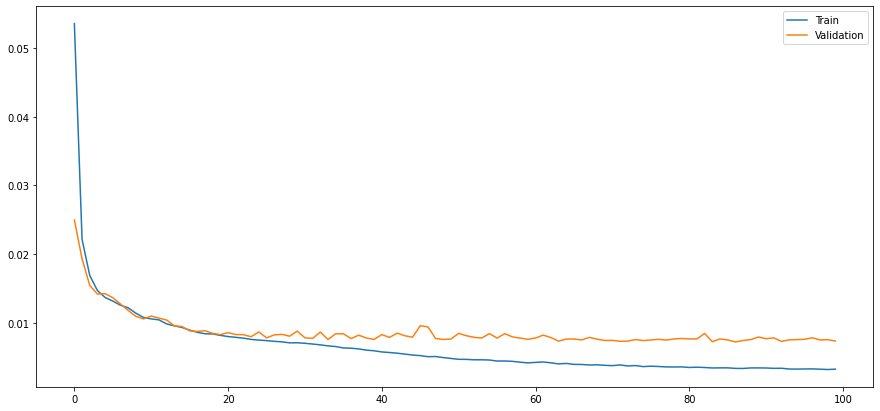

In [ ]:
fig = plt.figure(figsize=(15, 7))

plt.plot(train_loss)
plt.plot(val_loss)

plt.legend(["Train", "Validation"])

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [ ]:
pred_test = []
net.eval()
with torch.no_grad():
  for i, (black_withe_iamge, rgb) in enumerate(black_white_testloader):
        black_withe_iamge = black_withe_iamge.to(device)
        rgb = rgb.to(device)
        pred = net(black_withe_iamge)
        for each_black_withe_iamge, each_rgb, each_pred in zip(black_withe_iamge, rgb, pred):
            pred_test.append([each_black_withe_iamge.to('cpu'), each_rgb.to('cpu'), each_pred.to('cpu')])

sample_pred_test = sample(pred_test, 36)

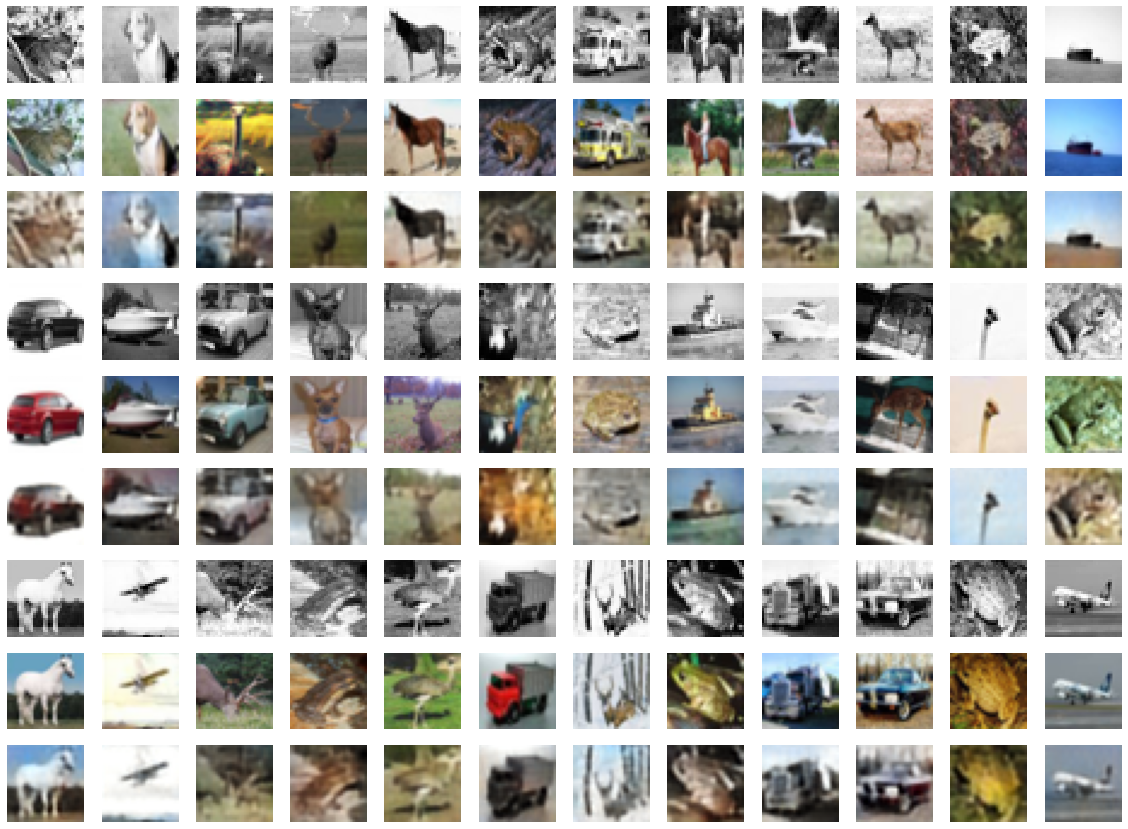

In [ ]:
fig = plt.figure(figsize=(20,15))

for each_sample in range(3):
  for i in range(12):
    black_withe_iamge , rgb, predict = sample_pred_test[each_sample * 12 + i]
    fig.add_subplot(9, 12, each_sample * 36 + i + 1)
    plt.imshow(black_withe_iamge.permute(1, 2, 0).numpy().reshape(32, 32), cmap='Greys_r', interpolation='nearest')
    plt.axis("off")
    fig.add_subplot(9, 12, each_sample * 36 + i + 12 + 1)
    plt.imshow(rgb.permute(1, 2, 0).numpy())
    plt.axis("off")
    fig.add_subplot(9, 12, each_sample * 36 + i + 24 + 1)
    plt.imshow(predict.permute(1, 2, 0).numpy())
    plt.axis("off")
plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm

from random import sample
from torch.utils.data import Dataset
import cv2

from time import time
from torchvision import transforms

In [ ]:
cuda = torch.device('cuda')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [ ]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

norm_rgb = Normalize(mean=(0.48, 0.48, 0.48), std=(0.2, 0.2, 0.2))
norm_black_white = Normalize(mean=(0.48, 0.48), std=(0.2, 0.2))

un_norm_rgb = UnNormalize(mean=(0.48, 0.48, 0.48), std=(0.2, 0.2, 0.2))
un_norm_black_white = UnNormalize(mean=(0.48, 0.48), std=(0.2, 0.2))

In [ ]:
class BlackWhiteDataset(torch.utils.data.Dataset):
  def __init__(self, train, root='./data', download = True , transform = None):
    self.is_train = train
    self.transform = transform
    self.pure_trainset = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)


  def __getitem__(self, idx):
    image, label = self.pure_trainset[idx]
    black_white_image = cv2.cvtColor(image.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2GRAY)
    black_white_image = black_white_image.reshape(1 ,32 ,32)
    black_white_image = torch.tensor(black_white_image)
    # return norm_black_white(black_white_image), norm_rgb(image)
    return black_white_image, image

  def __len__(self):
    return len(self.pure_trainset)

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [ ]:
def load_balck_white_trainset():
  transform_train = transforms.Compose([
    transforms.ToTensor(),
  ])
  trainset = BlackWhiteDataset(
      root='./data', 
      train=True, 
      download=True, 
      transform=transform_train
      )
  return trainset


def split_val_data_balck_white(trainset, train_ratio=0.9):
  train_size = int(train_ratio * len(trainset))
  val_size = len(trainset) - train_size

  train_set, val_set = torch.utils.data.random_split(trainset, (train_size, val_size))
  return train_set, val_set

def get_train_val_balck_white_loader(train_set, val_set):
  trainloader = torch.utils.data.DataLoader(
      train_set, batch_size=256, shuffle=True, num_workers=2
      )
  valloader = torch.utils.data.DataLoader(
      val_set, batch_size=512, shuffle=False, num_workers=2
      )
  return trainloader, valloader


def laod_balck_white_testset():
  transform_test = transforms.Compose([
    transforms.ToTensor(),
  ])
  testset = BlackWhiteDataset(
      root='./data', 
      train=False, 
      download=True, 
      transform=transform_test
      )
  return testset

def get_balck_white_test_loader(testset):
  testloader = torch.utils.data.DataLoader(
      testset, batch_size=512, shuffle=False, num_workers=2
      )
  return testloader
    

black_white_trainset = load_balck_white_trainset()
black_white_train_set, black_white_val_set = split_val_data_balck_white(black_white_trainset)
black_white_trainloader, black_white_valloader = get_train_val_balck_white_loader(black_white_train_set, black_white_val_set)


black_white_testset = laod_balck_white_testset()
black_white_testloader = get_balck_white_test_loader(black_white_testset)

Files already downloaded and verified
Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

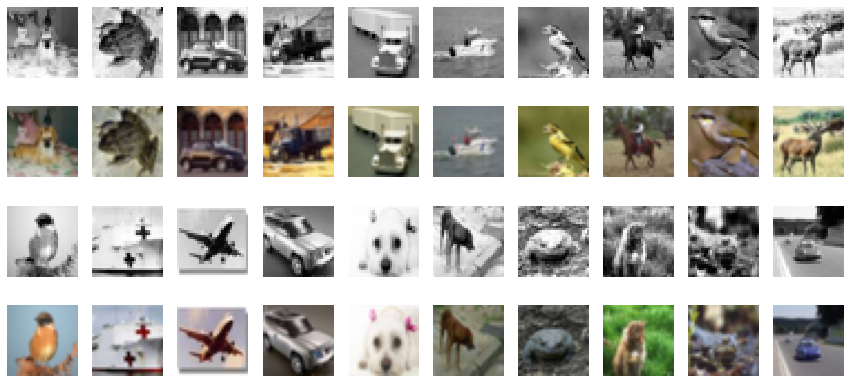

In [ ]:
fig = plt.figure(figsize=(15, 7))

balck_white_sample = sample([(black_white, rgb) for black_white, rgb in black_white_trainset], 20)

for both_sample in range(2):
  for i in range(10):
    black_withe_iamge , rgb = balck_white_sample[both_sample * 10 + i]
    fig.add_subplot(4, 10, both_sample * 20 + i + 1)
    # plt.imshow(un_norm_black_white(black_withe_iamge.clone().detach()).permute(1, 2, 0).numpy().reshape(32, 32), cmap='Greys_r', interpolation='nearest')
    plt.imshow(black_withe_iamge.permute(1, 2, 0).numpy().reshape(32, 32), cmap='Greys_r', interpolation='nearest')
    plt.axis("off")
    fig.add_subplot(4, 10, both_sample * 20 + i + 10 + 1)
    # plt.imshow(un_norm_rgb(rgb.clone().detach()).permute(1, 2, 0).numpy())
    plt.imshow(rgb.permute(1, 2, 0).numpy())
    plt.axis("off")


plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [ ]:
class ColNN(nn.Module):
    def __init__(self):
        super(ColNN, self).__init__()

        self.down1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
        )
        
        self.fc1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
        )
        self.fc2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
        )
        self.fc3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
        )

        
    def forward(self, x):
        d1 = self.down1(x)
        d1_relu = F.relu(d1)
        d2 = self.down2(d1_relu)
        d2_relu = F.relu(d2)
        d3 = self.down3(d2_relu)
        d3_relu = F.relu(d3)

        f1 = self.fc1(d3_relu)
        f1_relu = F.relu(f1)
        f2 = self.fc2(f1_relu)
        f2_relu = F.relu(f2)
        f3 = self.fc3(f2_relu)
        f3_relu = F.relu(f3)

        u1 = self.up1(f3_relu)
        u1_relu = F.relu(u1)
        u2 = self.up2(u1_relu)
        u2_relu = F.relu(u2)
        out = self.up3(u2_relu)
        
        return out

net = ColNN()
net = net.to('cuda')

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [ ]:
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-2)
criterion = nn.MSELoss()

def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader):
    count = 0
    average_loss = [0]
    i = 0

    net.train()
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (black_withe_iamge, rgb) in pbar:
          black_withe_iamge = black_withe_iamge.to(device)
          rgb = rgb.to(device)
          pred = net(black_withe_iamge)
          loss = criterion(pred, rgb)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          average_loss[-1] += loss.item()
          pbar.set_description(str(i))
          count += 1
    return average_loss[-1] / count

def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader):
    count = 0
    average_loss = [0]
    i = 0
    net.eval()
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (black_withe_iamge, rgb) in pbar:
          black_withe_iamge = black_withe_iamge.to(device)
          rgb = rgb.to(device)
          predict = net(black_withe_iamge)
          loss = criterion(predict, rgb)
          average_loss[-1] += loss.item()
          pbar.set_description(str(i))
          count += 1
    return average_loss[-1] / count

In [ ]:
epochs = 100
train_loss = []
val_loss = []

for e in range(epochs):

    start_time = time()

    train_res = train_epoch(net, criterion, optimizer, black_white_trainloader)
    train_loss.append(train_res)
    print('Train Loss:',train_res)
    val_res = eval_epoch(net, criterion, black_white_valloader)
    val_loss.append(val_res)
    print('Validation Loss:',val_res)

    end_time = time()

    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

175: 100%|██████████| 176/176 [00:12<00:00, 14.29it/s]

  Train Loss: 0.053535378919067705



9: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]

  Validation Loss: 0.024947321601212026
Epoch   1 finished in 14.12s



175: 100%|██████████| 176/176 [00:14<00:00, 12.14it/s]

  Train Loss: 0.022125369086014954



9: 100%|██████████| 10/10 [00:01<00:00,  9.28it/s]

  Validation Loss: 0.019313470274209977
Epoch   2 finished in 15.86s



175: 100%|██████████| 176/176 [00:10<00:00, 17.01it/s]

  Train Loss: 0.016887652206192302



9: 100%|██████████| 10/10 [00:01<00:00,  9.25it/s]

  Validation Loss: 0.015432551503181458
Epoch   3 finished in 11.67s



175: 100%|██████████| 176/176 [00:13<00:00, 12.98it/s]

  Train Loss: 0.014684514804023573



9: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]

  Validation Loss: 0.014172898046672345
Epoch   4 finished in 15.38s



175: 100%|██████████| 176/176 [00:12<00:00, 14.62it/s]


  Train Loss: 0.013676292183597318


9: 100%|██████████| 10/10 [00:01<00:00,  9.25it/s]

  Validation Loss: 0.014232831820845605
Epoch   5 finished in 13.40s



175: 100%|██████████| 176/176 [00:10<00:00, 17.19it/s]

  Train Loss: 0.013151595035610213



9: 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

  Validation Loss: 0.01364564374089241
Epoch   6 finished in 11.53s



175: 100%|██████████| 176/176 [00:10<00:00, 16.59it/s]


  Train Loss: 0.012555022798055275


9: 100%|██████████| 10/10 [00:01<00:00,  9.43it/s]

  Validation Loss: 0.012728412263095379
Epoch   7 finished in 11.92s



175: 100%|██████████| 176/176 [00:10<00:00, 16.68it/s]

  Train Loss: 0.01217404370915822



9: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s]

  Validation Loss: 0.01179666854441166
Epoch   8 finished in 11.85s



175: 100%|██████████| 176/176 [00:10<00:00, 16.63it/s]

  Train Loss: 0.01139531698374247



9: 100%|██████████| 10/10 [00:01<00:00,  9.46it/s]

  Validation Loss: 0.010932303871959448
Epoch   9 finished in 11.89s



175: 100%|██████████| 176/176 [00:10<00:00, 16.66it/s]

  Train Loss: 0.010765025614422153



9: 100%|██████████| 10/10 [00:01<00:00,  9.57it/s]

  Validation Loss: 0.01055787829682231
Epoch  10 finished in 11.83s



175: 100%|██████████| 176/176 [00:10<00:00, 17.19it/s]

  Train Loss: 0.01055998254080557



9: 100%|██████████| 10/10 [00:01<00:00,  9.73it/s]

  Validation Loss: 0.010975657869130373
Epoch  11 finished in 11.50s



175: 100%|██████████| 176/176 [00:10<00:00, 16.30it/s]

  Train Loss: 0.010424326221585612



9: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]

  Validation Loss: 0.010678805690258742
Epoch  12 finished in 12.13s



175: 100%|██████████| 176/176 [00:10<00:00, 16.39it/s]

  Train Loss: 0.009828546846454794



9: 100%|██████████| 10/10 [00:01<00:00,  9.12it/s]

  Validation Loss: 0.010404121782630681
Epoch  13 finished in 12.07s



175: 100%|██████████| 176/176 [00:10<00:00, 16.52it/s]

  Train Loss: 0.009552223851311614



9: 100%|██████████| 10/10 [00:01<00:00,  9.36it/s]

  Validation Loss: 0.009556775167584419
Epoch  14 finished in 11.95s



175: 100%|██████████| 176/176 [00:11<00:00, 15.87it/s]

  Train Loss: 0.009318225138651376



9: 100%|██████████| 10/10 [00:01<00:00,  9.59it/s]

  Validation Loss: 0.0094545166939497
Epoch  15 finished in 12.35s



175: 100%|██████████| 176/176 [00:10<00:00, 16.95it/s]

  Train Loss: 0.00892450320481492



9: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s]

  Validation Loss: 0.008819854445755481
Epoch  16 finished in 11.69s



175: 100%|██████████| 176/176 [00:10<00:00, 16.50it/s]

  Train Loss: 0.008608641153180295



9: 100%|██████████| 10/10 [00:01<00:00,  9.25it/s]

  Validation Loss: 0.008741117268800735
Epoch  17 finished in 11.98s



175: 100%|██████████| 176/176 [00:10<00:00, 16.80it/s]

  Train Loss: 0.008398775080091913



9: 100%|██████████| 10/10 [00:01<00:00,  9.58it/s]

  Validation Loss: 0.00884456057101488
Epoch  18 finished in 11.77s



175: 100%|██████████| 176/176 [00:10<00:00, 16.70it/s]


  Train Loss: 0.008365420603447339


9: 100%|██████████| 10/10 [00:01<00:00,  9.13it/s]

  Validation Loss: 0.008449561055749654
Epoch  19 finished in 11.87s



175: 100%|██████████| 176/176 [00:10<00:00, 16.06it/s]

  Train Loss: 0.008163572810272772



9: 100%|██████████| 10/10 [00:01<00:00,  9.11it/s]

  Validation Loss: 0.008275117073208094
Epoch  20 finished in 12.30s



175: 100%|██████████| 176/176 [00:10<00:00, 16.39it/s]

  Train Loss: 0.007990558965089307



9: 100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


  Validation Loss: 0.008561375364661217
Epoch  21 finished in 12.04s


175: 100%|██████████| 176/176 [00:10<00:00, 16.81it/s]

  Train Loss: 0.007878511175724932



9: 100%|██████████| 10/10 [00:01<00:00,  9.31it/s]

  Validation Loss: 0.008284362638369203
Epoch  22 finished in 11.77s



175: 100%|██████████| 176/176 [00:10<00:00, 16.91it/s]

  Train Loss: 0.007756189252673225



9: 100%|██████████| 10/10 [00:01<00:00,  9.58it/s]

  Validation Loss: 0.008259213902056218
Epoch  23 finished in 11.69s



175: 100%|██████████| 176/176 [00:10<00:00, 16.43it/s]

  Train Loss: 0.007574637700930576



9: 100%|██████████| 10/10 [00:01<00:00,  9.19it/s]

  Validation Loss: 0.007966539915651083
Epoch  24 finished in 12.04s



175: 100%|██████████| 176/176 [00:10<00:00, 16.19it/s]


  Train Loss: 0.007477015066383915


9: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

  Validation Loss: 0.008668825775384904
Epoch  25 finished in 12.17s



175: 100%|██████████| 176/176 [00:10<00:00, 16.16it/s]

  Train Loss: 0.00740101777641526



9: 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]

  Validation Loss: 0.0078007963486015795
Epoch  26 finished in 12.21s



175: 100%|██████████| 176/176 [00:10<00:00, 16.58it/s]

  Train Loss: 0.007293956475967372



9: 100%|██████████| 10/10 [00:01<00:00,  9.52it/s]

  Validation Loss: 0.008227601135149597
Epoch  27 finished in 11.91s



175: 100%|██████████| 176/176 [00:10<00:00, 16.69it/s]

  Train Loss: 0.007223424731901931



9: 100%|██████████| 10/10 [00:01<00:00,  9.48it/s]


  Validation Loss: 0.008309392770752311
Epoch  28 finished in 11.84s


175: 100%|██████████| 176/176 [00:10<00:00, 16.73it/s]

  Train Loss: 0.0070746124441608445



9: 100%|██████████| 10/10 [00:01<00:00,  9.10it/s]

  Validation Loss: 0.008046113653108478
Epoch  29 finished in 11.85s



175: 100%|██████████| 176/176 [00:10<00:00, 16.11it/s]


  Train Loss: 0.007087230007693341


9: 100%|██████████| 10/10 [00:01<00:00,  9.21it/s]

  Validation Loss: 0.008780715893954039
Epoch  30 finished in 12.25s



175: 100%|██████████| 176/176 [00:10<00:00, 16.41it/s]

  Train Loss: 0.007011015798938884



9: 100%|██████████| 10/10 [00:01<00:00,  9.57it/s]

  Validation Loss: 0.007804540731012821
Epoch  31 finished in 12.01s



175: 100%|██████████| 176/176 [00:10<00:00, 16.76it/s]

  Train Loss: 0.006900555880168791



9: 100%|██████████| 10/10 [00:01<00:00,  9.54it/s]

  Validation Loss: 0.007723333640024066
Epoch  32 finished in 11.78s



175: 100%|██████████| 176/176 [00:10<00:00, 16.63it/s]

  Train Loss: 0.006786268236200241



9: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s]

  Validation Loss: 0.00864996574819088
Epoch  33 finished in 11.85s



175: 100%|██████████| 176/176 [00:10<00:00, 16.80it/s]

  Train Loss: 0.00663265947051431



9: 100%|██████████| 10/10 [00:01<00:00,  9.65it/s]

  Validation Loss: 0.007557563995942473
Epoch  34 finished in 11.75s



175: 100%|██████████| 176/176 [00:10<00:00, 16.60it/s]

  Train Loss: 0.006537152438382195



9: 100%|██████████| 10/10 [00:01<00:00,  9.07it/s]

  Validation Loss: 0.00839590998366475
Epoch  35 finished in 11.95s



175: 100%|██████████| 176/176 [00:10<00:00, 16.05it/s]

  Train Loss: 0.006333246774209494



9: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

  Validation Loss: 0.008396419929340482
Epoch  36 finished in 12.32s



175: 100%|██████████| 176/176 [00:10<00:00, 16.40it/s]


  Train Loss: 0.006296513599491763


9: 100%|██████████| 10/10 [00:01<00:00,  9.26it/s]

  Validation Loss: 0.007698280457407236
Epoch  37 finished in 12.04s



175: 100%|██████████| 176/176 [00:10<00:00, 16.55it/s]

  Train Loss: 0.006192556344269013



9: 100%|██████████| 10/10 [00:01<00:00,  9.30it/s]


  Validation Loss: 0.008194594690576196
Epoch  38 finished in 11.94s


175: 100%|██████████| 176/176 [00:10<00:00, 16.48it/s]


  Train Loss: 0.006014522302641787


9: 100%|██████████| 10/10 [00:01<00:00,  9.34it/s]

  Validation Loss: 0.007767208339646459
Epoch  39 finished in 11.97s



175: 100%|██████████| 176/176 [00:10<00:00, 16.41it/s]

  Train Loss: 0.005923100466712971



9: 100%|██████████| 10/10 [00:01<00:00,  9.19it/s]

  Validation Loss: 0.0075750196352601055
Epoch  40 finished in 12.05s



175: 100%|██████████| 176/176 [00:10<00:00, 16.26it/s]

  Train Loss: 0.005751204904465174



9: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s]

  Validation Loss: 0.008275869721546768
Epoch  41 finished in 12.13s



175: 100%|██████████| 176/176 [00:10<00:00, 16.03it/s]

  Train Loss: 0.005669335149419071



9: 100%|██████████| 10/10 [00:01<00:00,  9.30it/s]

  Validation Loss: 0.00786881260573864
Epoch  42 finished in 12.29s



175: 100%|██████████| 176/176 [00:10<00:00, 16.66it/s]

  Train Loss: 0.005568361481313001



9: 100%|██████████| 10/10 [00:01<00:00,  9.52it/s]

  Validation Loss: 0.008489261660724879
Epoch  43 finished in 11.85s



175: 100%|██████████| 176/176 [00:10<00:00, 16.79it/s]

  Train Loss: 0.005436996553643522



9: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]

  Validation Loss: 0.00810406133532524
Epoch  44 finished in 11.81s



175: 100%|██████████| 176/176 [00:10<00:00, 16.48it/s]


  Train Loss: 0.00530273084719242


9: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]

  Validation Loss: 0.007901416951790452
Epoch  45 finished in 12.04s



175: 100%|██████████| 176/176 [00:11<00:00, 15.88it/s]

  Train Loss: 0.005213889327768067



9: 100%|██████████| 10/10 [00:01<00:00,  9.00it/s]

  Validation Loss: 0.009562401752918958
Epoch  46 finished in 12.43s



175: 100%|██████████| 176/176 [00:11<00:00, 15.85it/s]


  Train Loss: 0.005060485908126628


9: 100%|██████████| 10/10 [00:01<00:00,  9.03it/s]

  Validation Loss: 0.009402448125183583
Epoch  47 finished in 12.47s



175: 100%|██████████| 176/176 [00:10<00:00, 16.29it/s]

  Train Loss: 0.00508448528919623



9: 100%|██████████| 10/10 [00:01<00:00,  9.64it/s]


  Validation Loss: 0.007695460366085172
Epoch  48 finished in 12.07s


175: 100%|██████████| 176/176 [00:10<00:00, 16.37it/s]

  Train Loss: 0.00492513342495923



9: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]

  Validation Loss: 0.007571707572788
Epoch  49 finished in 12.07s



175: 100%|██████████| 176/176 [00:10<00:00, 16.39it/s]

  Train Loss: 0.00480511485577815



9: 100%|██████████| 10/10 [00:01<00:00,  9.31it/s]

  Validation Loss: 0.007628863630816341
Epoch  50 finished in 12.06s



175: 100%|██████████| 176/176 [00:10<00:00, 16.59it/s]

  Train Loss: 0.004678591183619574



9: 100%|██████████| 10/10 [00:01<00:00,  9.23it/s]

  Validation Loss: 0.0084594895131886
Epoch  51 finished in 11.92s



175: 100%|██████████| 176/176 [00:10<00:00, 16.42it/s]

  Train Loss: 0.004669859042306515



9: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

  Validation Loss: 0.008109938912093639
Epoch  52 finished in 12.09s



175: 100%|██████████| 176/176 [00:11<00:00, 15.87it/s]

  Train Loss: 0.004606557277094742



9: 100%|██████████| 10/10 [00:01<00:00,  9.08it/s]

  Validation Loss: 0.00788145437836647
Epoch  53 finished in 12.43s



175: 100%|██████████| 176/176 [00:10<00:00, 16.00it/s]

  Train Loss: 0.004609341865447773



9: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

  Validation Loss: 0.0077753834892064335
Epoch  54 finished in 12.35s



175: 100%|██████████| 176/176 [00:10<00:00, 16.08it/s]

  Train Loss: 0.004576840275231833



9: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

  Validation Loss: 0.008417313918471336
Epoch  55 finished in 12.24s



175: 100%|██████████| 176/176 [00:10<00:00, 16.38it/s]

  Train Loss: 0.00442736852644223



9: 100%|██████████| 10/10 [00:01<00:00,  9.12it/s]

  Validation Loss: 0.007765893265604973
Epoch  56 finished in 12.08s



175: 100%|██████████| 176/176 [00:11<00:00, 15.79it/s]

  Train Loss: 0.004434134155003862



9: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]

  Validation Loss: 0.00841801194474101
Epoch  57 finished in 12.49s



175: 100%|██████████| 176/176 [00:10<00:00, 16.02it/s]

  Train Loss: 0.004383175795241682



9: 100%|██████████| 10/10 [00:01<00:00,  9.45it/s]

  Validation Loss: 0.007938588690012693
Epoch  58 finished in 12.31s



175: 100%|██████████| 176/176 [00:10<00:00, 16.70it/s]

  Train Loss: 0.004259332722127015



9: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]

  Validation Loss: 0.007766751851886511
Epoch  59 finished in 11.90s



175: 100%|██████████| 176/176 [00:10<00:00, 16.28it/s]

  Train Loss: 0.004160907746567814



9: 100%|██████████| 10/10 [00:01<00:00,  9.32it/s]

  Validation Loss: 0.007593536237254739
Epoch  60 finished in 12.13s



175: 100%|██████████| 176/176 [00:10<00:00, 16.50it/s]

  Train Loss: 0.004228635986113328



9: 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

  Validation Loss: 0.007772425469011068
Epoch  61 finished in 11.97s



175: 100%|██████████| 176/176 [00:10<00:00, 16.55it/s]

  Train Loss: 0.004293735960593701



9: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

  Validation Loss: 0.00819903202354908
Epoch  62 finished in 11.93s



175: 100%|██████████| 176/176 [00:10<00:00, 16.17it/s]

  Train Loss: 0.004167345044234852



9: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]

  Validation Loss: 0.007846928434446454
Epoch  63 finished in 12.30s



175: 100%|██████████| 176/176 [00:11<00:00, 15.70it/s]

  Train Loss: 0.004012086322869767



9: 100%|██████████| 10/10 [00:01<00:00,  8.97it/s]

  Validation Loss: 0.007322528259828686
Epoch  64 finished in 12.57s



175: 100%|██████████| 176/176 [00:11<00:00, 15.79it/s]

  Train Loss: 0.004082782145071013



9: 100%|██████████| 10/10 [00:01<00:00,  8.92it/s]

  Validation Loss: 0.007625159015879035
Epoch  65 finished in 12.53s



175: 100%|██████████| 176/176 [00:10<00:00, 16.25it/s]

  Train Loss: 0.003941104687824422



9: 100%|██████████| 10/10 [00:01<00:00,  9.48it/s]

  Validation Loss: 0.007636115700006485
Epoch  66 finished in 12.13s



175: 100%|██████████| 176/176 [00:11<00:00, 15.92it/s]

  Train Loss: 0.003930631948275153



9: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]

  Validation Loss: 0.007497605634853244
Epoch  67 finished in 12.41s



175: 100%|██████████| 176/176 [00:11<00:00, 15.76it/s]

  Train Loss: 0.003854065614921803



9: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]

  Validation Loss: 0.007872892683371902
Epoch  68 finished in 12.57s



175: 100%|██████████| 176/176 [00:10<00:00, 16.01it/s]

  Train Loss: 0.0038795910487268966



9: 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

  Validation Loss: 0.0076110541820526125
Epoch  69 finished in 12.29s



175: 100%|██████████| 176/176 [00:10<00:00, 16.18it/s]

  Train Loss: 0.0038068939214678144



9: 100%|██████████| 10/10 [00:01<00:00,  9.51it/s]

  Validation Loss: 0.007423880137503147
Epoch  70 finished in 12.19s



175: 100%|██████████| 176/176 [00:10<00:00, 16.27it/s]


  Train Loss: 0.003756868184692311


9: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]

  Validation Loss: 0.007436213875189423
Epoch  71 finished in 12.14s



175: 100%|██████████| 176/176 [00:10<00:00, 16.28it/s]

  Train Loss: 0.003860287254528058



9: 100%|██████████| 10/10 [00:01<00:00,  9.37it/s]

  Validation Loss: 0.007301984960213304
Epoch  72 finished in 12.11s



175: 100%|██████████| 176/176 [00:10<00:00, 16.37it/s]

  Train Loss: 0.003713277402725494



9: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

  Validation Loss: 0.007328256359323859
Epoch  73 finished in 12.08s



175: 100%|██████████| 176/176 [00:10<00:00, 16.20it/s]

  Train Loss: 0.0037725280126323923



9: 100%|██████████| 10/10 [00:01<00:00,  8.89it/s]

  Validation Loss: 0.007555508706718683
Epoch  74 finished in 12.22s



175: 100%|██████████| 176/176 [00:11<00:00, 15.58it/s]

  Train Loss: 0.0036162593751214445



9: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]

  Validation Loss: 0.007407772820442915
Epoch  75 finished in 12.67s



175: 100%|██████████| 176/176 [00:11<00:00, 15.78it/s]

  Train Loss: 0.0036788790484107185



9: 100%|██████████| 10/10 [00:01<00:00,  9.48it/s]


  Validation Loss: 0.007487827772274613
Epoch  76 finished in 12.46s


175: 100%|██████████| 176/176 [00:10<00:00, 16.29it/s]

  Train Loss: 0.003632600751271556



9: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]

  Validation Loss: 0.007593920920044184
Epoch  77 finished in 12.18s



175: 100%|██████████| 176/176 [00:11<00:00, 15.60it/s]


  Train Loss: 0.003574659617945806


9: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

  Validation Loss: 0.007471915613859892
Epoch  78 finished in 12.64s



175: 100%|██████████| 176/176 [00:10<00:00, 16.18it/s]

  Train Loss: 0.0035614099073096772



9: 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

  Validation Loss: 0.007643595291301608
Epoch  79 finished in 12.18s



175: 100%|██████████| 176/176 [00:10<00:00, 16.51it/s]

  Train Loss: 0.0035799447730162433



9: 100%|██████████| 10/10 [00:01<00:00,  9.23it/s]

  Validation Loss: 0.0077086527366191145
Epoch  80 finished in 11.99s



175: 100%|██████████| 176/176 [00:10<00:00, 16.14it/s]


  Train Loss: 0.0034924489617961544


9: 100%|██████████| 10/10 [00:01<00:00,  9.17it/s]

  Validation Loss: 0.00765105988830328
Epoch  81 finished in 12.24s



175: 100%|██████████| 176/176 [00:10<00:00, 16.19it/s]

  Train Loss: 0.00353214369203091



9: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]

  Validation Loss: 0.007638331595808267
Epoch  82 finished in 12.17s



175: 100%|██████████| 176/176 [00:10<00:00, 16.17it/s]

  Train Loss: 0.003487818421986462



9: 100%|██████████| 10/10 [00:01<00:00,  9.20it/s]

  Validation Loss: 0.00844482984393835
Epoch  83 finished in 12.21s



175: 100%|██████████| 176/176 [00:10<00:00, 16.30it/s]

  Train Loss: 0.0034202557858820496



9: 100%|██████████| 10/10 [00:01<00:00,  9.38it/s]

  Validation Loss: 0.00724213202483952
Epoch  84 finished in 12.12s



175: 100%|██████████| 176/176 [00:11<00:00, 15.62it/s]

  Train Loss: 0.0034334168713857334



9: 100%|██████████| 10/10 [00:01<00:00,  8.96it/s]

  Validation Loss: 0.007643475569784642
Epoch  85 finished in 12.63s



175: 100%|██████████| 176/176 [00:11<00:00, 15.54it/s]


  Train Loss: 0.003437616195614365


9: 100%|██████████| 10/10 [00:01<00:00,  8.92it/s]

  Validation Loss: 0.007498117536306382
Epoch  86 finished in 12.70s



175: 100%|██████████| 176/176 [00:11<00:00, 15.70it/s]

  Train Loss: 0.0033607151272008196



9: 100%|██████████| 10/10 [00:01<00:00,  9.43it/s]

  Validation Loss: 0.007206492917612195
Epoch  87 finished in 12.53s



175: 100%|██████████| 176/176 [00:10<00:00, 16.45it/s]


  Train Loss: 0.0033466210033194247


9: 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]

  Validation Loss: 0.007418809831142426
Epoch  88 finished in 11.99s



175: 100%|██████████| 176/176 [00:11<00:00, 15.84it/s]

  Train Loss: 0.003425194371216507



9: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]

  Validation Loss: 0.007552163442596793
Epoch  89 finished in 12.46s



175: 100%|██████████| 176/176 [00:11<00:00, 15.83it/s]

  Train Loss: 0.003425165132450109



9: 100%|██████████| 10/10 [00:01<00:00,  9.18it/s]

  Validation Loss: 0.0079251604154706
Epoch  90 finished in 12.46s



175: 100%|██████████| 176/176 [00:10<00:00, 16.19it/s]

  Train Loss: 0.00341645983280614



9: 100%|██████████| 10/10 [00:01<00:00,  9.40it/s]

  Validation Loss: 0.007676397589966655
Epoch  91 finished in 12.19s



175: 100%|██████████| 176/176 [00:10<00:00, 16.36it/s]

  Train Loss: 0.0033667390909448095



9: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]

  Validation Loss: 0.007799186557531357
Epoch  92 finished in 12.13s



175: 100%|██████████| 176/176 [00:10<00:00, 16.27it/s]

  Train Loss: 0.0033750912791054525



9: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

  Validation Loss: 0.007294726790860295
Epoch  93 finished in 12.14s



175: 100%|██████████| 176/176 [00:10<00:00, 16.18it/s]

  Train Loss: 0.0032656279495726762



9: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s]

  Validation Loss: 0.007512621162459254
Epoch  94 finished in 12.20s



175: 100%|██████████| 176/176 [00:11<00:00, 15.64it/s]

  Train Loss: 0.003255571650118906



9: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

  Validation Loss: 0.007547010574489832
Epoch  95 finished in 12.62s



175: 100%|██████████| 176/176 [00:11<00:00, 15.71it/s]

  Train Loss: 0.0032743456315736034



9: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]

  Validation Loss: 0.007592784706503153
Epoch  96 finished in 12.58s



175: 100%|██████████| 176/176 [00:10<00:00, 16.05it/s]

  Train Loss: 0.0032836481008086016



9: 100%|██████████| 10/10 [00:01<00:00,  9.65it/s]

  Validation Loss: 0.007814596639946103
Epoch  97 finished in 12.24s



175: 100%|██████████| 176/176 [00:10<00:00, 16.35it/s]


  Train Loss: 0.0032429827948693524


9: 100%|██████████| 10/10 [00:01<00:00,  9.28it/s]

  Validation Loss: 0.007499971333891154
Epoch  98 finished in 12.09s



175: 100%|██████████| 176/176 [00:10<00:00, 16.22it/s]

  Train Loss: 0.003196230316957967



9: 100%|██████████| 10/10 [00:01<00:00,  9.47it/s]

  Validation Loss: 0.007535501103848219
Epoch  99 finished in 12.15s



175: 100%|██████████| 176/176 [00:10<00:00, 16.43it/s]


  Train Loss: 0.003243934873766689


9: 100%|██████████| 10/10 [00:01<00:00,  9.56it/s]

  Validation Loss: 0.0073431506752967834
Epoch 100 finished in 12.00s


### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

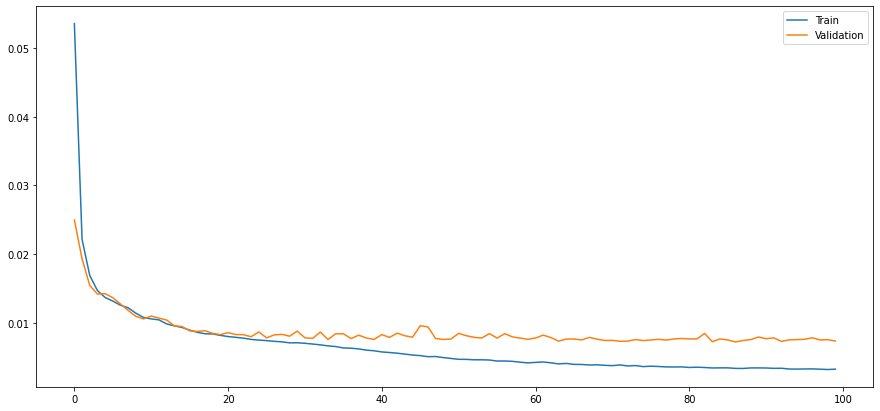

In [ ]:
fig = plt.figure(figsize=(15, 7))

plt.plot(train_loss)
plt.plot(val_loss)

plt.legend(["Train", "Validation"])

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [ ]:
pred_test = []
net.eval()
with torch.no_grad():
  for i, (black_withe_iamge, rgb) in enumerate(black_white_testloader):
        black_withe_iamge = black_withe_iamge.to(device)
        rgb = rgb.to(device)
        pred = net(black_withe_iamge)
        for each_black_withe_iamge, each_rgb, each_pred in zip(black_withe_iamge, rgb, pred):
            pred_test.append([each_black_withe_iamge.to('cpu'), each_rgb.to('cpu'), each_pred.to('cpu')])

sample_pred_test = sample(pred_test, 36)

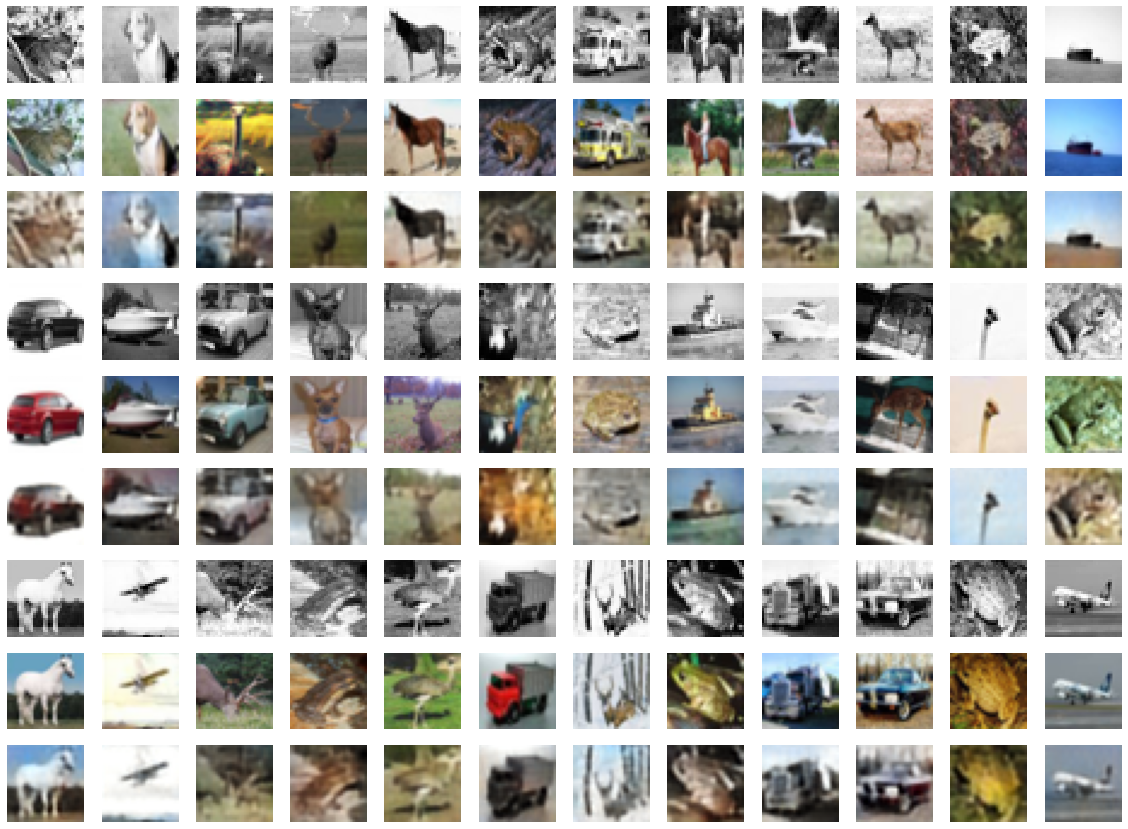

In [ ]:
fig = plt.figure(figsize=(20,15))

for each_sample in range(3):
  for i in range(12):
    black_withe_iamge , rgb, predict = sample_pred_test[each_sample * 12 + i]
    fig.add_subplot(9, 12, each_sample * 36 + i + 1)
    plt.imshow(black_withe_iamge.permute(1, 2, 0).numpy().reshape(32, 32), cmap='Greys_r', interpolation='nearest')
    plt.axis("off")
    fig.add_subplot(9, 12, each_sample * 36 + i + 12 + 1)
    plt.imshow(rgb.permute(1, 2, 0).numpy())
    plt.axis("off")
    fig.add_subplot(9, 12, each_sample * 36 + i + 24 + 1)
    plt.imshow(predict.permute(1, 2, 0).numpy())
    plt.axis("off")
plt.show()